# Tweet like a futur president

This notebook is split into 5 parts :
- `Installation` provides code to install all packages and functions we used
- `Download data` downloads models we trained and tweets we gathered
- `Descriptive statistics` contains statistics and simple analysis on the tweets we studied
- `Our results` contains functions that let people sample new tweets
- `Training` contains functions that describes how we learnt each model.

👉 Play with our results in this [cell](#scrollTo=DwAyJ7QaZcmB)


# 💽 Installation

Installation of `transformers` that is usefull for training models such as GPT2

In [ ]:
!pip install transformers

In [ ]:
!pip install langdetect

In [ ]:
import torch
from torch import nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer 
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import numpy as np
import random
from langdetect import detect, DetectorFactory
import nltk
from collections import Counter
from nltk import TweetTokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 🔽 Download data with used for our project and all models we learnt

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1r6khuV7A8iSpHv0fI4qhro-JZHS4yIg7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1r6khuV7A8iSpHv0fI4qhro-JZHS4yIg7" -O "download.zip" && rm -rf /tmp/cookies.txt

--2022-04-24 15:31:03--  https://docs.google.com/uc?export=download&confirm=t&id=1r6khuV7A8iSpHv0fI4qhro-JZHS4yIg7
Resolving docs.google.com (docs.google.com)... 172.217.204.138, 172.217.204.100, 172.217.204.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/52s6keldem17klbna0ohq26ctk12nh72/1650814200000/05161437614602880006/*/1r6khuV7A8iSpHv0fI4qhro-JZHS4yIg7?e=download [following]
--2022-04-24 15:31:04--  https://doc-0o-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/52s6keldem17klbna0ohq26ctk12nh72/1650814200000/05161437614602880006/*/1r6khuV7A8iSpHv0fI4qhro-JZHS4yIg7?e=download
Resolving doc-0o-bc-docs.googleusercontent.com (doc-0o-bc-docs.googleusercontent.com)... 173.194.211.132, 2607:f8b0:400c:c10::84
Connecting to doc-0o-bc-docs.googleusercontent.com (doc-

In [ ]:
!unzip /content/download.zip -d  /content/data

Archive:  /content/download.zip
replace /content/data/data/LePen/tweets_JulienOdoul.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data/data/LePen/tweets_JulienOdoul.csv  
  inflating: /content/data/data/LePen/tweets_J_Bardella.csv  
  inflating: /content/data/data/LePen/tweets_MLP_officiel.csv  
  inflating: /content/data/data/LePen/tweets_RNational_off.csv  
  inflating: /content/data/data/Macron/tweets_avecvous.csv  
  inflating: /content/data/data/Macron/tweets_CCastaner.csv  
  inflating: /content/data/data/Macron/tweets_EmmanuelMacron.csv  
  inflating: /content/data/data/Macron/tweets_StanGuerini.csv  
  inflating: /content/data/data/Melenchon/tweets_AQuatennens.csv  
  inflating: /content/data/data/Melenchon/tweets_Francois_Ruffin.csv  
  inflating: /content/data/data/Melenchon/tweets_jlmelenchon.csv  
  inflating: /content/data/data/Melenchon/tweets_melenchon_2022.csv  
  inflating: /content/data/data/Pecresse/tweets_avecValerie.csv  
  inflating: /content/

# ℹ Descriptive Statistics

## Import and clean data

In [ ]:
mypath = r"/content/data/data"

In [ ]:
file_names = []

for path, currentDirectory, files in os.walk(mypath):
    for file in files:
        file_names.append(os.path.join(path, file))

In [ ]:
candidat_names = [path.split("/")[-2] for path in file_names]

names = [re.findall(r'[^/]+(?=\.)',path)[0] for path in file_names]

dataframes = [pd.read_csv(path) for path in file_names]

`data` contains a dictionnary with the name of csv files and the dataframe as values. 

In [ ]:
dataframes_by_account = dict(zip(names,dataframes))

In [ ]:
a = list(zip(names,candidat_names))

dataframe_by_candidat = {}

for candidat in set(candidat_names):
    list_accounts = [elem for elem in a if elem[1] == candidat]
    data_list_accounts = [dataframes_by_account[elem[0]] for elem in list_accounts]
    data_list_accounts = pd.concat(data_list_accounts, axis = 0, ignore_index = True)
    dataframe_by_candidat[candidat] = data_list_accounts

In [ ]:
def remove_emot_url(dataframe):
    res = dataframe.copy()
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002500-\U00002BEF"  # chinese char
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u1000-\u1090" #myanmar alphabet
                        u"\u0400-\u04F0" #cyrillic alphabet
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u23F0-\u23FB"
                        u"\u274C-\u274E"
                        u"\u2196-\u2199"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                        u"\u2028"
                        u"\u21AA"  
                        u"\u2139"
                        u"\u2066"
                        u"\u2069"
                        u"\u203C"
                        u"\u2009"
                        u"\u27A1"
                        u"\u2192"
                        u"\u2022"
                        u"\u21B4"
                        u"\u2193"
                        u"\u21A9"
                        u"\u00AD"
                        u"\u1D49"
                        u"\u200b"
                        "]+", flags=re.UNICODE)
    
    for i in range(len(res["text_tweet"])):
        res["text_tweet"][i] = re.sub(r'http\S+', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'\n', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'\r', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'İ', 'i', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'\xa0', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'⃣', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = emoji_pattern.sub(r'', res["text_tweet"][i])
        res["text_tweet"][i] = res["text_tweet"][i].lower()
        if len(re.sub(r' |[^\w\s]|\d+', '', res["text_tweet"][i], flags=re.MULTILINE)) == 0:
            res.drop(i, inplace = True)
    return res

In [ ]:
res = [remove_emot_url(dataframe_by_candidat["LePen"]), remove_emot_url(dataframe_by_candidat["Zemmour"]), remove_emot_url(dataframe_by_candidat["Pecresse"]), remove_emot_url(dataframe_by_candidat["Melenchon"]), remove_emot_url(dataframe_by_candidat["Macron"])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
def remove_not_french_tweets(res):
    DetectorFactory.seed = 0
    for i in res["text_tweet"].index:
        if detect(res["text_tweet"][i]) != 'fr':
            res.drop(i, inplace = True)
    return res

In [ ]:
for r in range(len(res)):
    res[r] = remove_not_french_tweets(res[r])

In [ ]:
candidates = ["Le Pen" , "Zemmour", "Pécresse", "Mélenchon", "Macron"]

## Number of tweets per candidate

In [ ]:
print("Number of tweets by candidat after removing empty and not french sentence:")

for i in range (len(candidates)):
    print(f"{candidates[i]} : {len(res[i])}")

Number of tweets by candidat after removing empty and not french sentence:
Le Pen : 8481
Zemmour : 5605
Pécresse : 6858
Mélenchon : 8141
Macron : 7129


We can see that the candidate for whom we have the most tweets is Marine Le Pen with 8481 tweets. Conversely, the candidate for whom we have the fewest tweets is Zemmour with 5605 tweets. This is significantly smaller than for the other 4 candidates.

## Tweets' length per candidate

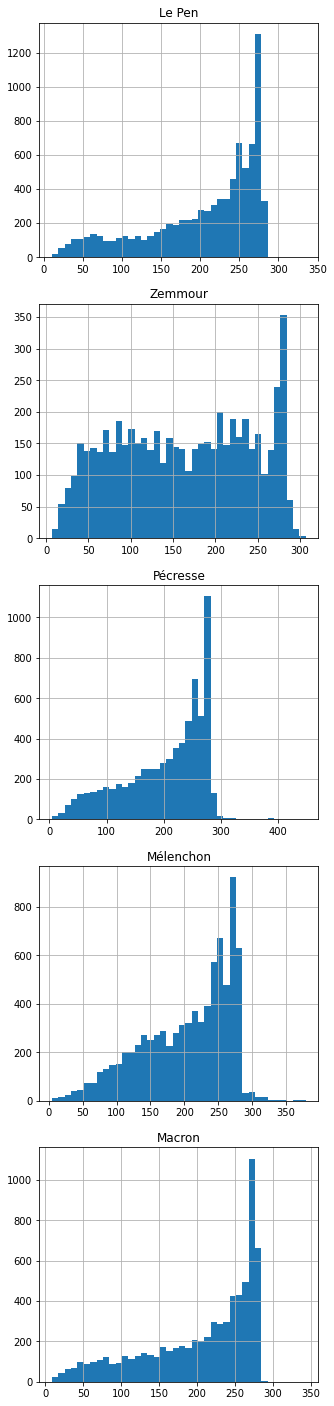

In [ ]:
fig, axs = plt.subplots(len(set(candidat_names)), figsize=(5, 25))
mean_len_tweets = []
for r in range(len(candidates)):
    len_tweets = res[r].text_tweet.apply(len)
    mean_len_tweets.append(np.mean(len_tweets))
    len_tweets.hist(bins = 40,ax=axs[r])
    axs[r].title.set_text(candidates[r])

For Macron, Le Pen, Mélenchon and Pécresse, we see that the distribution of the number of characters is spread out to the right. This can be explained by the fact that the maximum number of characters on twitter is 280. The candidates therefore often use these 280 characters. For Zemmour, the distribution is more uniform with a mass around 280 all the same.

In [ ]:
print("Average number of characters per candidate :")
for r in range(len(candidates)):
    print(f"{candidates[r]} : {mean_len_tweets[r]}")

Average number of characters per candidate :
Le Pen : 205.86652517391818
Zemmour : 162.57163247100803
Pécresse : 203.20355788859726
Mélenchon : 204.6033656798919
Macron : 205.03071959601627


We see that the average number of characters is almost identical for Le Pen, Macron, Mélenchon and Pécresse (205 characters). As for Zemmour, it is much lower: about 163 characters. Coupled with the fact that we have fewer tweets for Zemmour, this means that we will have less data to train the model associated with Zemmour.

## Most frequent words per candidate

Tokenize and remove stopwords and punctuation

In [ ]:
from tqdm import tqdm
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french') + ["a", "cette", "cet", "comme", "plus", "tous", "tout", "être", "c'est", "ceux", "ça", "si", "fait", "faire", "quand", "leurs", "depuis", "aussi", "pen", "faut", "doit"])

s =  set("!\"$%&'()*+,-./:;<=>?[\]^_`{|}~’«»").union(set(['...']))

def tokenize(corpus, tweets=False):
    if tweets:
        tokenizer = TweetTokenizer()
    else:
        tokenizer = TreebankWordTokenizer()  
    tokenized_sentences = []
    for sample in tqdm(corpus):
        tokens = tokenizer.tokenize(sample)
        filtered_tweets = []
        for w in tokens:
            if w not in stop_words and w not in s:
                filtered_tweets.append(w)
        tokenized_sentences.append(filtered_tweets)
    return tokenized_sentences

In [ ]:
res_tokens = []
for r in range(len(res)):
    res_tokens.append(tokenize(res[r].text_tweet, True))

100%|██████████| 7129/7129 [00:03<00:00, 2299.55it/s]


In [ ]:
def list_tot(tokens):
    tot = []
    for t in tokens:
        tot = tot + t
    return tot

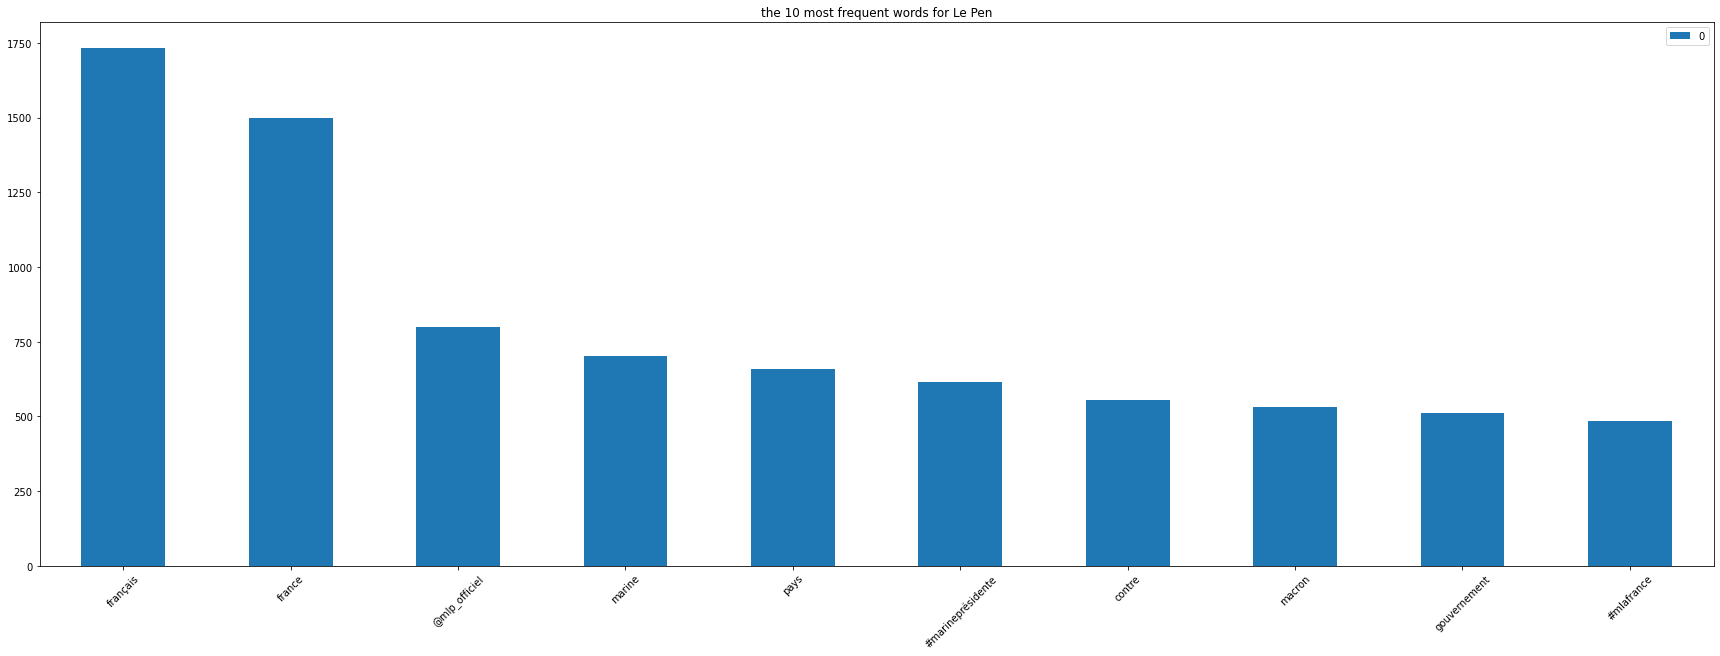

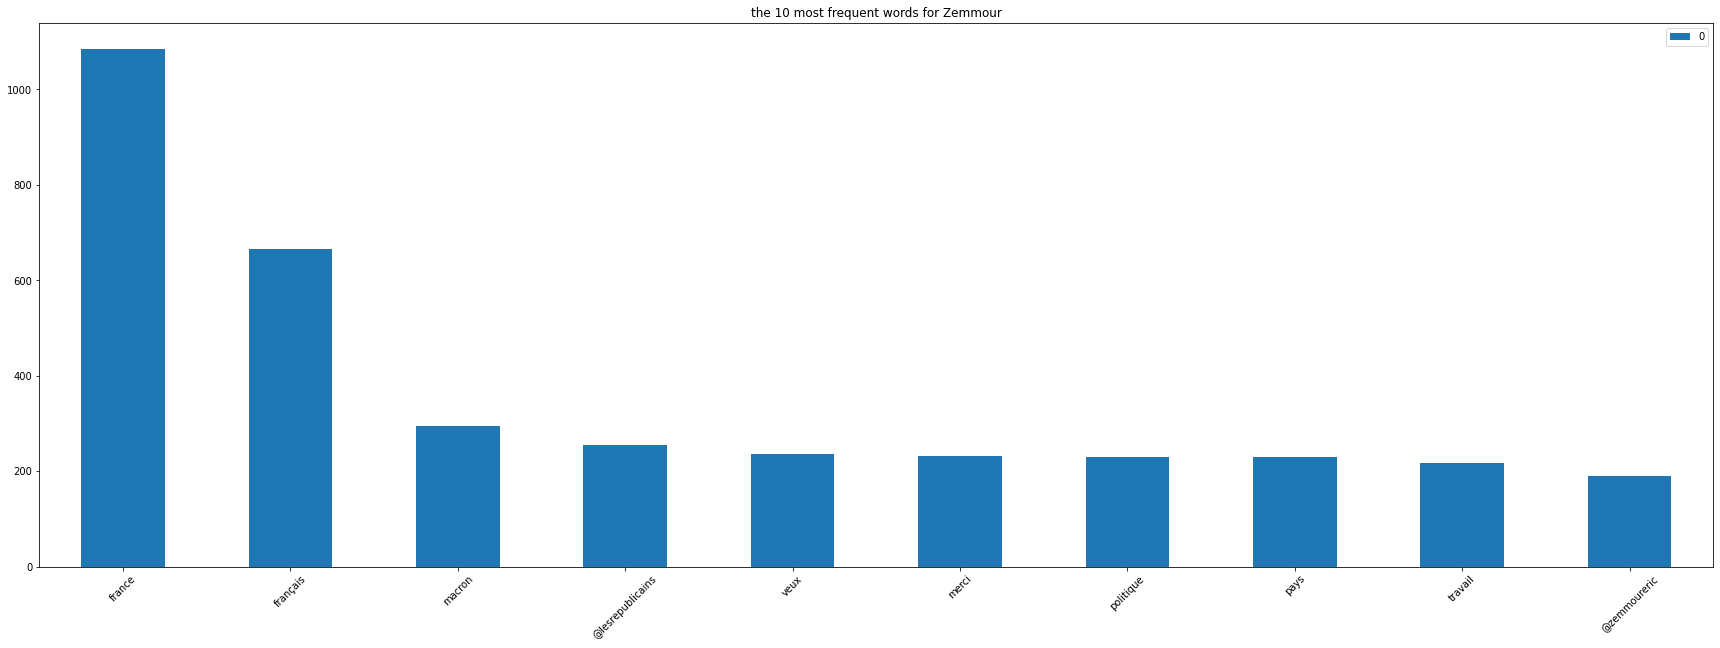

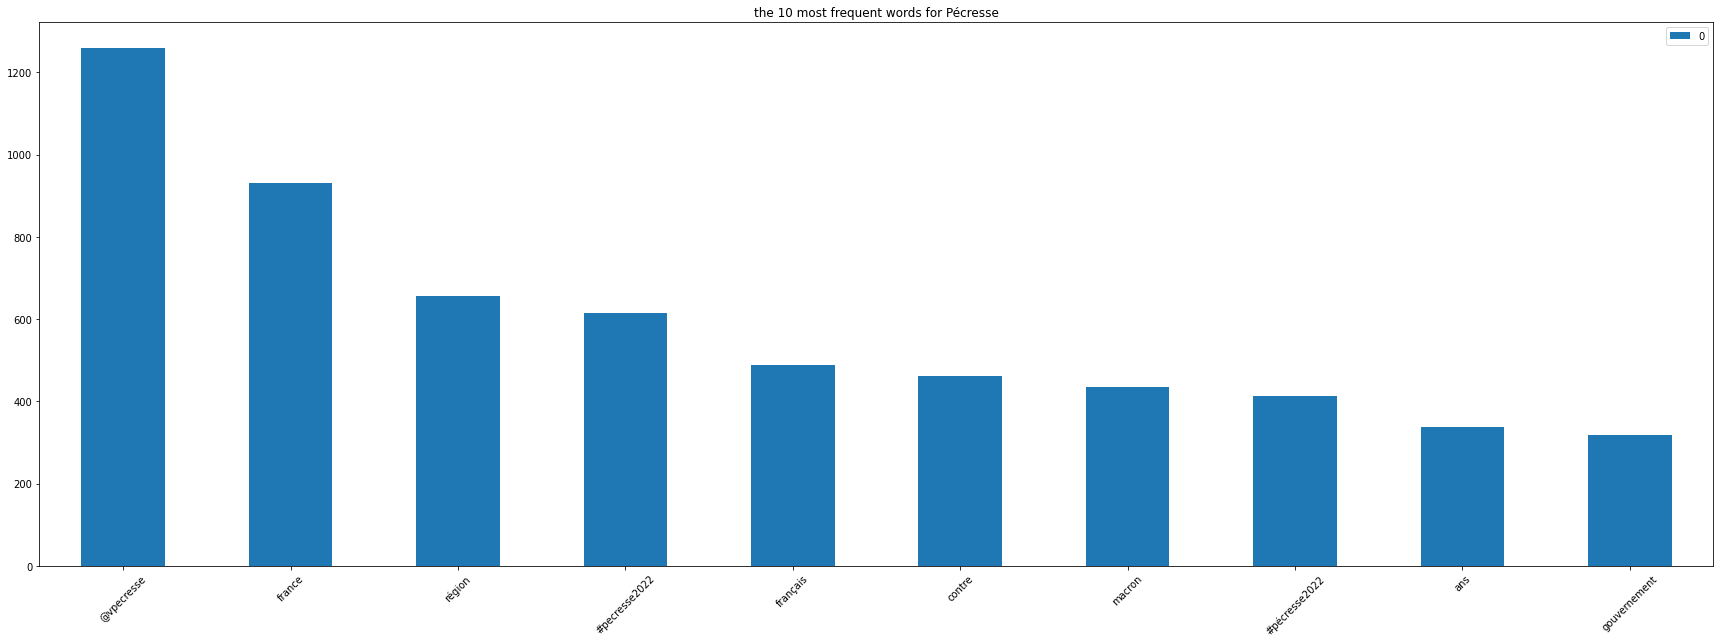

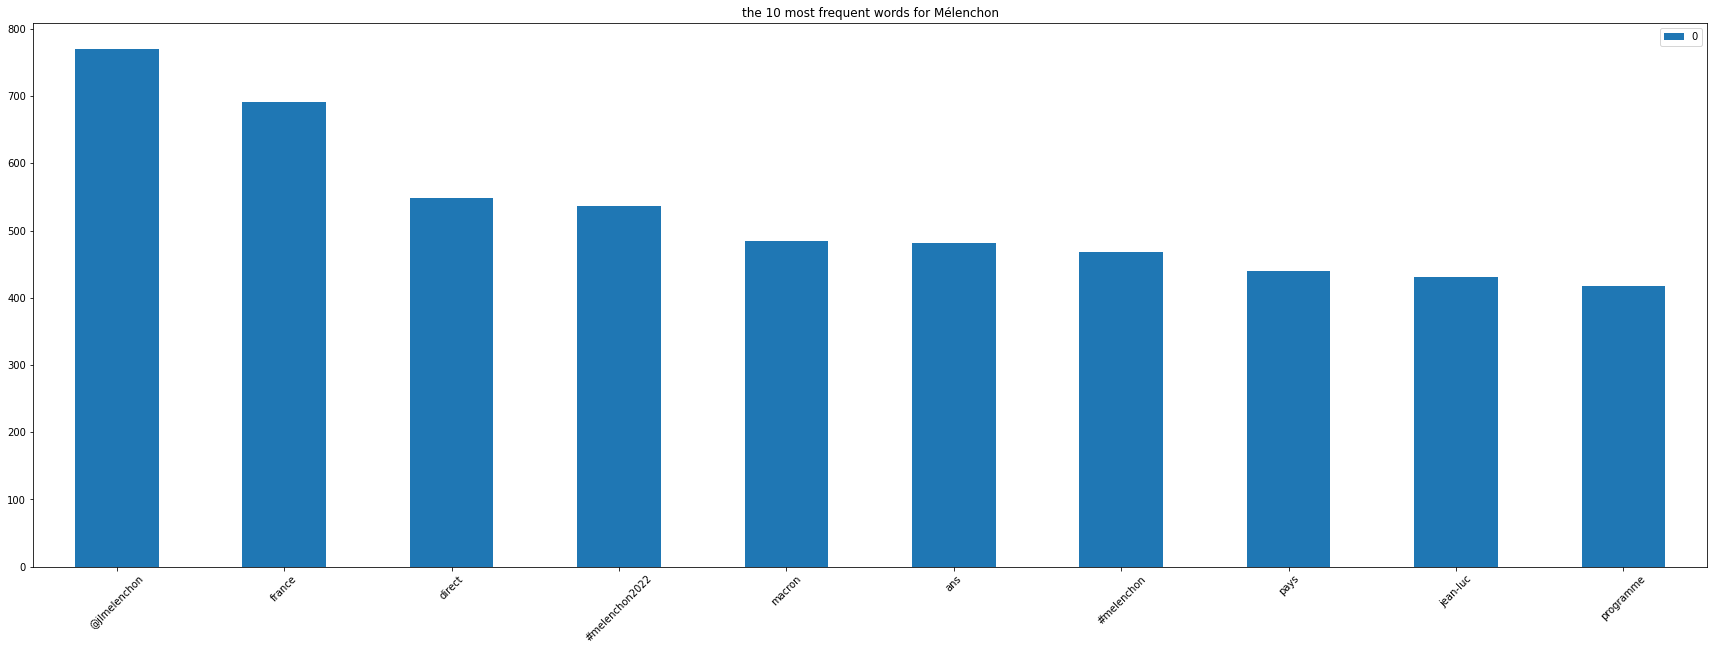

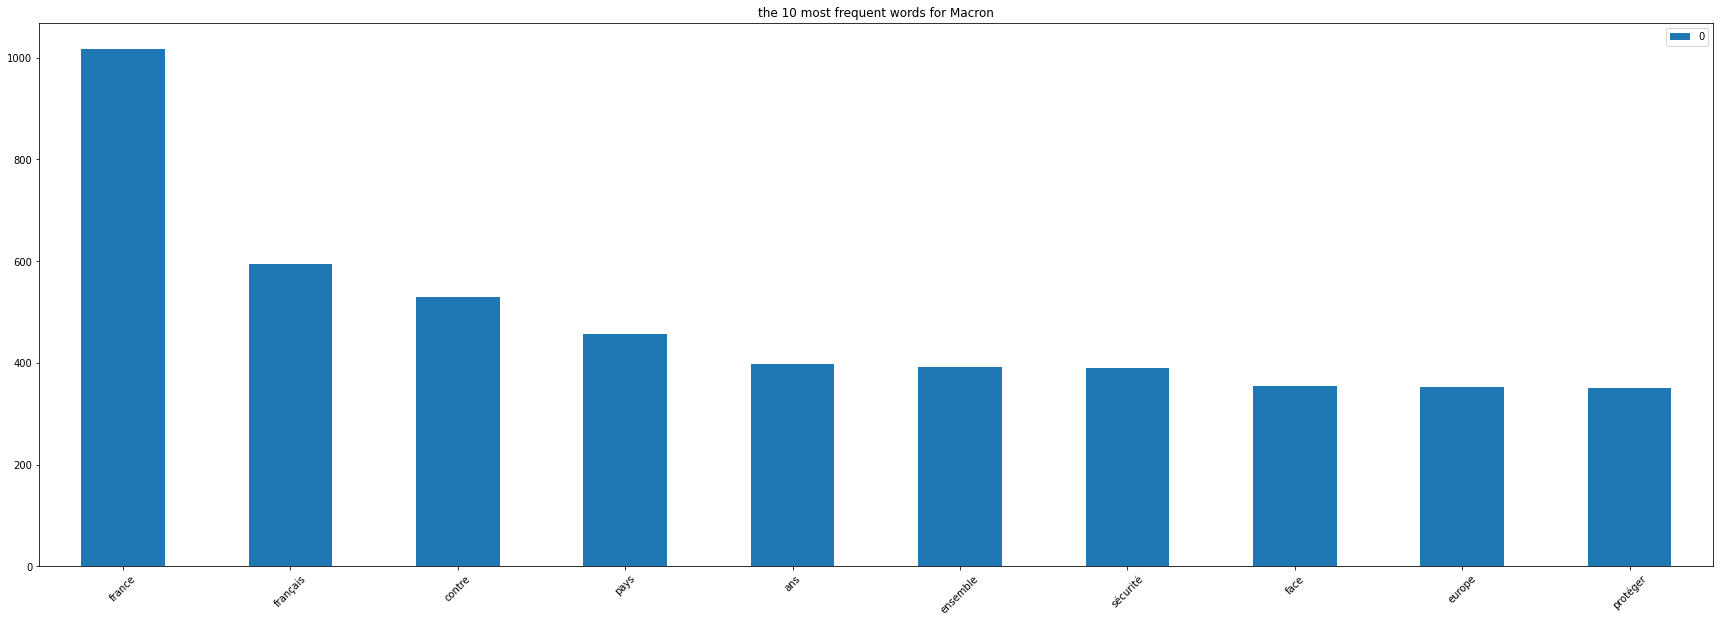

In [ ]:

for r in range (len(res_tokens)):
    word_counts = Counter(list_tot(res_tokens[r]))
    df = pd.DataFrame.from_dict(word_counts, orient='index')
    df = df.sort_values(by = 0, ascending = False)
    df[:10].plot(kind = "bar", rot = 45,figsize=(30,10))
    plt.title(f'the 10 most frequent words for {candidates[r]}')

For all candidates except Macron, and to a lesser extent for Zemmour, their # and @ are often used. In addition, for all the candidates, the words "France" and "français" are very present. For the far-right candidates, Le Pen and Zemmour, these words are used to a very large extent. For example, for Zemmour, the word "France" is used almost 4 times more than the 3rd most used word and the word "français" 2 times more. For Macron these words are also widely used but to a slightly lesser extent.
We also notice that all the candidates often write Macron, except himself. The words "sécurité" and "protéger" are frequent in Macron's tweets, as are the words "ensemble" and "europe".

# ⭐ Our results :


## With GPT-2

In [ ]:
def print_res_GPT2(start_str, list_model_tok, length):
  for model,tokenizer,name in list_model_tok:
      #encode text :
      encode_start_str = tokenizer_MLP.encode(start_str)
      model.eval()
      output = model.generate(
                  bos_token_id= torch.Tensor(encode_start_str).long(),
                  do_sample=True,   
                  top_k=50, 
                  max_length= length,
                  top_p=0.95, 
                  num_return_sequences=1,
                  pad_token_id = 50256
      )

      # Decode it
      decoded_output = []
      for sample in output:
          decoded_output.append(tokenizer.decode(sample, skip_special_tokens=True))
      print(name + "  :  " + " ".join(decoded_output))

### Le Pen

In [ ]:
model_MLP = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_MLP = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")
model_MLP.load_state_dict(torch.load('data/models/gpt2/model_MLP.pt',torch.device('cpu')))

Downloading:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/951k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/519k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

<All keys matched successfully>

### Macron

In [ ]:
model_macron = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_macron = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")
model_macron.load_state_dict(torch.load('data/models/gpt2/model_macron.pt',torch.device('cpu')))

<All keys matched successfully>

### Mélenchon

In [ ]:
model_mel = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_mel = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")
model_mel.load_state_dict(torch.load('data/models/gpt2/model_mel.pt',torch.device('cpu')))

<All keys matched successfully>

### Zemmour

In [ ]:
model_zemmour = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_zemmour = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")
model_zemmour.load_state_dict(torch.load('data/models/gpt2/model_zemmour.pt',torch.device('cpu')))

<All keys matched successfully>

### Pécresse

In [ ]:
model_pecresse = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_pecresse = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")
model_pecresse.load_state_dict(torch.load('data/models/gpt2/model_pecresse.pt',torch.device('cpu')))

<All keys matched successfully>

## With LSTM

In [ ]:
from torch import nn

class Model(nn.Module):
    def __init__(self, n_letters):
        super(Model, self).__init__()
        self.lstm_size = n_letters*7
        self.fc_size = n_letters*4
        self.num_layers = 3
        self.linear_dim = self.lstm_size*seq_length
        
        self.lstm = nn.LSTM(
            input_size= n_letters,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first = True)
        
        self.bn1 = nn.BatchNorm1d(self.lstm_size)
        self.selu1 = nn.SELU()
            
        self.fc1 = nn.Linear(self.lstm_size, self.fc_size)
        self.selu2 = nn.SELU()
            
        self.fc2 = nn.Linear(self.fc_size, self.fc_size)
        self.bn2 = nn.BatchNorm1d(self.fc_size)
        self.selu3 = nn.SELU()
        
        self.fc3 = nn.Linear(self.fc_size, n_letters)
            
    def forward(self, x):
            
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        #output = output.reshape(output.size(0), -1)
        output = self.bn1(output)
        output = self.selu1(output)
        
        output = self.fc1(output)
        output = self.selu2(output)
        
        output = self.fc2(output)
        output = self.bn2(output)
        output = self.selu3(output)
        
        output = self.fc3(output)
        return output
    
    def init_state(self, sequence_length):
        
        return (torch.zeros(self.num_layers, seq_length, self.lstm_size),
                torch.zeros(self.num_layers, seq_length, self.lstm_size))

In [ ]:
seq_length = 40

In [ ]:
all_letters_lepen =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’â«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủč—´²×·º") 
all_letters_melenchon =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’â«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủč—´²×·º") 
all_letters_zemmour =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’â«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủčđåć—´²×·º¡") 
all_letters_macron =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’â«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủčđåć—´²×·º¡") 
all_letters_pecresse =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’ˋâ«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủčđåć—´²×·º¡") 

In [ ]:
n_letters_lepen = len(all_letters_lepen)
n_letters_melenchon = len(all_letters_melenchon)
n_letters_macron = len(all_letters_macron)
n_letters_zemmour = len(all_letters_zemmour)
n_letters_pecresse = len(all_letters_pecresse)

### Le Pen

In [ ]:
model_lepen_lstm = Model(n_letters_lepen)
model_lepen_lstm.load_state_dict(torch.load("/content/data/models/lstm/modele_lepen.pt",map_location=torch.device('cpu')))
model_lepen_lstm.eval()

Model(
  (lstm): LSTM(117, 819, num_layers=3, batch_first=True, dropout=0.2)
  (bn1): BatchNorm1d(819, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu1): SELU()
  (fc1): Linear(in_features=819, out_features=468, bias=True)
  (selu2): SELU()
  (fc2): Linear(in_features=468, out_features=468, bias=True)
  (bn2): BatchNorm1d(468, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu3): SELU()
  (fc3): Linear(in_features=468, out_features=117, bias=True)
)

### Macron

In [ ]:
model_macron_lstm = Model(n_letters_macron)
model_macron_lstm.load_state_dict(torch.load("/content/data/models/lstm/modele_macron.pt",map_location=torch.device('cpu')))
model_macron_lstm.eval()

Model(
  (lstm): LSTM(121, 847, num_layers=3, batch_first=True, dropout=0.2)
  (bn1): BatchNorm1d(847, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu1): SELU()
  (fc1): Linear(in_features=847, out_features=484, bias=True)
  (selu2): SELU()
  (fc2): Linear(in_features=484, out_features=484, bias=True)
  (bn2): BatchNorm1d(484, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu3): SELU()
  (fc3): Linear(in_features=484, out_features=121, bias=True)
)

### Pécresse

In [ ]:
model_pecresse_lstm = Model(n_letters_pecresse)
model_pecresse_lstm.load_state_dict(torch.load("/content/data/models/lstm/modele_pecresse.pt",map_location=torch.device('cpu')))
model_pecresse_lstm.eval()

Model(
  (lstm): LSTM(122, 854, num_layers=3, batch_first=True, dropout=0.2)
  (bn1): BatchNorm1d(854, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu1): SELU()
  (fc1): Linear(in_features=854, out_features=488, bias=True)
  (selu2): SELU()
  (fc2): Linear(in_features=488, out_features=488, bias=True)
  (bn2): BatchNorm1d(488, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu3): SELU()
  (fc3): Linear(in_features=488, out_features=122, bias=True)
)

### Mélenchon

In [ ]:
model_melenchon_lstm = Model(n_letters_melenchon)
model_melenchon_lstm.load_state_dict(torch.load("/content/data/models/lstm/modele_melenchon.pt",map_location=torch.device('cpu')))
model_melenchon_lstm.eval()

Model(
  (lstm): LSTM(117, 819, num_layers=3, batch_first=True, dropout=0.2)
  (bn1): BatchNorm1d(819, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu1): SELU()
  (fc1): Linear(in_features=819, out_features=468, bias=True)
  (selu2): SELU()
  (fc2): Linear(in_features=468, out_features=468, bias=True)
  (bn2): BatchNorm1d(468, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu3): SELU()
  (fc3): Linear(in_features=468, out_features=117, bias=True)
)

### Zemmour

In [ ]:
model_zemmour_lstm = Model(n_letters_zemmour)
model_zemmour_lstm.load_state_dict(torch.load("/content/data/models/lstm/modele_zemmour.pt",map_location=torch.device('cpu')))
model_zemmour_lstm.eval()

Model(
  (lstm): LSTM(121, 847, num_layers=3, batch_first=True, dropout=0.2)
  (bn1): BatchNorm1d(847, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu1): SELU()
  (fc1): Linear(in_features=847, out_features=484, bias=True)
  (selu2): SELU()
  (fc2): Linear(in_features=484, out_features=484, bias=True)
  (bn2): BatchNorm1d(484, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu3): SELU()
  (fc3): Linear(in_features=484, out_features=121, bias=True)
)

## Sample like each candidat

### GPT-2

In [ ]:
model_pretrained = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_pretrained = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")

In [ ]:
list_model = [(model_MLP, tokenizer_MLP, "MLP"), 
              (model_macron, tokenizer_macron, "macron"),
              (model_mel, tokenizer_mel, "melenchon"),
              (model_zemmour, tokenizer_zemmour, "zemmour"),
              (model_pecresse, tokenizer_pecresse, "pécresse"),
              (model_pretrained, tokenizer_pretrained, "pretrained")]



In [ ]:
print_res_GPT2("@JLMelenchon", list_model,40)

MLP  :  @JLMelenchon à l' UMP, et au parti socialiste à la primaire de la gauche et du centre ", avait alors annoncé le numéro deux du parti.Le numéro trois avait annoncé en
macron  :  @JLMelenchon. Ce qui m' a donné beaucoup de peine : ) ( Merci pour tous vos messages! Par ailleurs, le recours à une assurance responsabilité civile professionnelle pour le salarié qui vient
melenchon  :  @JLMelenchon, je ne suis pas un crétin, je suis un humain! L' autre grand événement de la journée, c' est la fête du sport avec la présence de l
zemmour  :  @JLMelenchon : " Moi-même, j' ai voté Macron " ( vidéo ) Marine Le Pen : " Le Pen, c' est la trahison des électeurs " ( vidéo ) Le
pécresse  :  @JLMelenchon est le président du Parti, mais n' ai pas le soutien de ma famille politique. Il est donc très difficile de la définir en ces termes, parce que ce serait trop
pretrained  :  @JLMelenchon qui n' en pouvait plus de se battre ( oui, c' est vrai, c' est une idée que j' ai depuis très longtemps ). Ce

In [ ]:
print_res_GPT2("l'écologie", list_model,40)

MLP  :  les français sont trop jeunes pour qu' on les voit à terre ", dénonce une habitante de la région nantaise. " En attendant de donner l' avis de la commission de discipline, nous
macron  :  les français sont également très inquiets : seuls 36 % des personnes interrogées envisagent une fin de la politique d' austérité et du plan de rigueur contre 43 % en octobre. Une solution parfaite pour votre projet :
melenchon  :  les français sont en guerre, mais pas l' un ni l' autre! " Ce qui est sûr, c' est qu' elle pourrait gagner cette course à l' Élysée ", assure-
zemmour  :  les français sont-ils encore plus inquiets de la montée des tensions en Ukraine? Dans la matinée, la police a mené une perquisition dans son domicile. Le nombre d' élèves, la réussite aux examens
pécresse  :  les français sont invités à s' exprimer sur cet hommage qui s' inscrit au coeur de l' action de l' association. L' enjeu aujourd' hui, c' est de construire un écosystème
pretrained  :  les français sont des ho

In [ ]:
print_res_GPT2("@MLP_officiel", list_model,40)

MLP  :  @MLP_officiel à la fois discret et efficace pour l analyse d images J ai réalisé cette vidéo en partenariat avec le Club de la Presse. Tout comme, j' ai une envie folle
macron  :  @MLP_officiel. Et le dernier mot revient à l' article 7 bis, à son amendement du 5 février 2013, qui propose une dérogation au droit de préemption urbain, afin d
melenchon  :  @MLP_officiel de gestion pour l' entrepriseProgrammation de l' application vmware vmware vmware vmware vmware vmware vmware
zemmour  :  @MLP_officielMaturation _ 1.Smitterrand _ 2.Code _ 3. Ces gens se voient et se font remarquer par la hiérarchie locale qui s' éver
pécresse  :  @MLP_officiel " En savoir plus... N' oubliez pas qu' une grande variété de programmes d' affiliation est disponible! Je préfère attendre un peu pour faire le point ". "
pretrained  :  @MLP_officiel des archives de la marque. Vous pouvez trouver un grand choix de tissus en soie, satin et denim. Le film s' est classé dans le top 20 d'


In [ ]:
print_res_GPT2("La constitution", list_model,40)

MLP  :  La constitution du Groupe Banque Populaire ( groupe BPCE ) dont il est un des principaux acteurs, et, aujourd' hui, les fonctions d' intermédiation commerciale, de gestion des risques et d'
macron  :  La constitution du 1er octobre 1958 est la première à garantir le droit à une protection sociale intégrale pour tous, y compris aux fonctionnaires et aux retraités. Et pourtant, les gens qui font du cinéma ne
melenchon  :  La constitution des unités militaires à la fin du XVIIIe siècle et au début du XIXe siècle en Indochine. Le gouvernement français a donc pris le problème très au sérieux et s' est engagé à aider les victimes
zemmour  :  La constitution de l' échantillon de population : une approche qui respecte la diversité des individus. Dans notre région, à l' arrivée du TGV en décembre dernier, les gares parisiennes et les centres de logistique
pécresse  :  La constitution de cette fondation est prévue pour une durée de 4 ans et s' inscrit dans le cadre des Objectifs du Millé

### LSTM

In [ ]:
def sample(preds, temperature=1.0):
    preds = torch.log(preds) / temperature
    exp_preds = torch.exp(preds)
    preds = exp_preds / torch.sum(exp_preds)
    probas = torch.multinomial(preds[0], 1)
    return probas

In [ ]:
def predict(model, base_tweet, length, n_letters, stoi, itos, diversity):
    seq_length = 40
    state_h, state_c = model.init_state(seq_length)
    softmax = nn.Softmax(dim=1)
    generated = ''
    base = base_tweet[0: seq_length]
    generated += base
    model.eval()
    with torch.no_grad():
        for i in range(length - seq_length):
            x_pred = np.zeros((1, seq_length, n_letters))
            for t, char in enumerate(base):
                x_pred[0, t, stoi[char]] = 1.
            
            x_pred = torch.from_numpy(x_pred).float()
            preds = model(x_pred)
            preds = softmax(preds)
            preds = preds.detach()
            next_index = sample(preds, diversity)
            next_char = itos[next_index]

            generated += next_char
            base = base[1:] + next_char
    print(base_tweet[0: seq_length])
    print(generated)
    
    return (base_tweet[0: seq_length], generated)

In [ ]:
stoi_lepen = {letter : idx for idx, letter in enumerate(all_letters_lepen)}
itos_lepen = [letter for idx, letter in enumerate(all_letters_lepen)]

stoi_melenchon = {letter : idx for idx, letter in enumerate(all_letters_melenchon)}
itos_melenchon = [letter for idx, letter in enumerate(all_letters_melenchon)]

stoi_macron = {letter : idx for idx, letter in enumerate(all_letters_macron)}
itos_macron = [letter for idx, letter in enumerate(all_letters_macron)]

stoi_zemmour = {letter : idx for idx, letter in enumerate(all_letters_zemmour)}
itos_zemmour = [letter for idx, letter in enumerate(all_letters_zemmour)]

stoi_pecresse = {letter : idx for idx, letter in enumerate(all_letters_pecresse)}
itos_pecresse = [letter for idx, letter in enumerate(all_letters_pecresse)]

In [ ]:
diversity = 0.5

In [ ]:
len("concernant la guerre en ukraine, je pense")

40

the length of base_tweet must be at least 40 characters

In [ ]:
base, generated = predict(model_lepen_lstm, "concernant la guerre en ukraine, je pense ", 150, n_letters_lepen, stoi_lepen, itos_lepen, diversity)

concernant la guerre en ukraine,je pense
concernant la guerre en ukraine,je pense de très faire sa porte de conseiller régional de #laréunion, les mesures de chaque année 2020 et son identité


In [ ]:
base, generated = predict(model_melenchon_lstm, "concernant la guerre en ukraine, je pense ", 150, n_letters_melenchon, stoi_melenchon, itos_melenchon, diversity)

concernant la guerre en ukraine,je pense
concernant la guerre en ukraine,je pense que le progrès de la france n’est pas de proposition de défendre le covid.   #melenchonsaintdenis            


In [ ]:
base, generated = predict(model_pecresse_lstm, "concernant la guerre en ukraine, je pense ", 150, n_letters_pecresse, stoi_pecresse, itos_pecresse, diversity)

concernant la guerre en ukraine,je pense
concernant la guerre en ukraine,je pense pour les franciliens avec @vpecresse au service de l’intégration de la république, de la présidence des masqu


In [ ]:
base, generated = predict(model_macron_lstm, "concernant la guerre en ukraine, je pense ", 150, n_letters_macron, stoi_macron, itos_macron, diversity)

concernant la guerre en ukraine,je pense
concernant la guerre en ukraine,je pense aux français avec les forces de l'ordre. c’est cela que nous agirons et son système de santé. c'est la meille


In [ ]:
base, generated = predict(model_zemmour_lstm, "concernant la guerre en ukraine, je pense ", 150, n_letters_zemmour, stoi_zemmour, itos_zemmour, diversity)

concernant la guerre en ukraine,je pense
concernant la guerre en ukraine,je pense qu’il faut revenir sur que l’état a rejourné leur réseau agriculture. mais nous sommes le bataclan et de la f


# 🕔 Training 

## GPT2

### Explanatory data analysis 

In [ ]:
n_min = 60

In [ ]:
mypath = r'/content/data/data'
file_names = []

for path, currentDirectory, files in os.walk(mypath):
    for file in files:
        file_names.append(os.path.join(path, file))

In [ ]:
candidat_names = [path.split("/")[-2] for path in file_names] #change on ubuntu

names = [re.findall(r'[^\\]+(?=\.)',path)[0] for path in file_names]

dataframes = [pd.read_csv(path) for path in file_names]

In [ ]:
dataframes_by_account = dict(zip(names,dataframes))
a = list(zip(names,candidat_names))

dataframe_by_candidat = {}

for candidat in set(candidat_names):
    list_accounts = [elem for elem in a if elem[1] == candidat]
    data_list_accounts = [dataframes_by_account[elem[0]] for elem in list_accounts]
    data_list_accounts = pd.concat(data_list_accounts, axis = 0, ignore_index = True)
    dataframe_by_candidat[candidat] = data_list_accounts

In [ ]:
def remove_hashtag_url(dataframe):
    res = dataframe.copy()
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002500-\U00002BEF"  # chinese char
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u23F0-\u23FB"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                        u"\u2028"
                        u"\u21AA"  
                        u"\u2139"
                        u"\u2066"
                        u"\u2069"
                        u"\u203C"
                        "]+", flags=re.UNICODE)
    
    for i in range(len(res["text_tweet"])):
        res["text_tweet"][i] = re.sub(r'http\S+', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'\n', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'https', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'⃣', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = emoji_pattern.sub(r'', res["text_tweet"][i])
        res["text_tweet"][i] = res["text_tweet"][i].lower()
        if len(re.sub(r' ', '', res["text_tweet"][i], flags=re.MULTILINE)) == 0:
            res.drop(i, inplace = True)

    res = res[res["text_tweet"].apply(len) > n_min]
    return res

In [ ]:
def tokenize(df):
    tokenized_sentences = []
    for s in df["text_tweet"]:
        L= []
        for char in s:
            L.append(char)
        tokenized_sentences.append(L)
    return tokenized_sentences

### Training of each model

#### Definition of training funcions

In [ ]:
class TweetCandidat(Dataset):
    def __init__(self, df_tweets, tokenizer):

        self.tokenizer = tokenizer
        self.tweets = []

        for row in df_tweets["text_tweet"]:

            self.tweets.append(torch.tensor(
                self.tokenizer.encode('<|startoftext|>' + row ) #add endoftext
            ))    
          
        
    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        return self.tweets[item]

In [ ]:
#Accumulated batch size (since GPT2 is so big)
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [ ]:
def train(
    dataset, model, tokenizer,
    batch_size=128, epochs=100, lr=2e-5,
    max_seq_len=280, warmup_steps=200,
    output_dir=".", output_prefix="",
    test_mode=False,save_model_on_epoch=False,batch_size_train = 1
):
    acc_steps = 100
    device=torch.device("cuda")
    model = model.cuda()
    model.train()

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
    )

    train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)
    loss=0
    losses = [torch.tensor(np.inf)]
    accumulating_batch_count = 0
    input_tensor = None
    best_model = None
    
    for epoch in range(epochs):

        print(f"Training epoch {epoch}")
        for idx, entry in tqdm(enumerate(train_dataloader)):
            (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

            if carry_on and idx != len(train_dataloader) - 1:
                continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            loss.backward()

            if (accumulating_batch_count % batch_size) == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            accumulating_batch_count += 1
            input_tensor = None
        if loss < losses[-1]:
            best_model = model.state_dict().copy()
        losses.append(loss)
        if save_model_on_epoch:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),
            )
            
    return model,losses, best_model

#### Training step

##### Le Pen

In [ ]:
model_MLP = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_MLP = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")

res_MLP = remove_hashtag_url(dataframe_by_candidat["LePen"])

res_MLP = res_MLP[res_MLP["text_tweet"].apply(len) > n_min]

data_MLP = TweetCandidat(res_MLP, tokenizer_MLP)

res_mlp = train(data_MLP,model_MLP, tokenizer_MLP, epochs = 100, lr=1e-6)

In [ ]:
torch.save(model_macron.state_dict(), "model_MLP.pt")

##### Macron

In [ ]:
model_macron = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_macron = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")

res_macron = remove_hashtag_url(dataframe_by_candidat["Macron"])

res_macron = res_macron[res_macron["text_tweet"].apply(len) > n_min]

data_macron = TweetCandidat(res_macron, tokenizer_macron)

train(data_macron,model_macron, tokenizer_macron, epochs = 100, lr=1e-6)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to b

Training epoch 0


7004it [02:08, 54.35it/s]
0it [00:00, ?it/s]

Training epoch 1


7004it [02:14, 51.92it/s]
0it [00:00, ?it/s]

Training epoch 2


7004it [02:14, 52.26it/s]
0it [00:00, ?it/s]

Training epoch 3


7004it [02:13, 52.64it/s]
0it [00:00, ?it/s]

Training epoch 4


7004it [02:12, 52.73it/s]
0it [00:00, ?it/s]

Training epoch 5


7004it [02:12, 52.76it/s]
0it [00:00, ?it/s]

Training epoch 6


7004it [02:12, 52.79it/s]
0it [00:00, ?it/s]

Training epoch 7


7004it [02:12, 52.82it/s]
0it [00:00, ?it/s]

Training epoch 8


7004it [02:12, 52.78it/s]
0it [00:00, ?it/s]

Training epoch 9


7004it [02:12, 52.74it/s]
0it [00:00, ?it/s]

Training epoch 10


7004it [02:11, 53.09it/s]
0it [00:00, ?it/s]

Training epoch 11


7004it [02:12, 52.90it/s]
0it [00:00, ?it/s]

Training epoch 12


7004it [02:12, 52.81it/s]
0it [00:00, ?it/s]

Training epoch 13


7004it [02:12, 52.66it/s]
0it [00:00, ?it/s]

Training epoch 14


7004it [02:12, 52.73it/s]
0it [00:00, ?it/s]

Training epoch 15


7004it [02:12, 52.75it/s]
0it [00:00, ?it/s]

Training epoch 16


7004it [02:12, 52.89it/s]
0it [00:00, ?it/s]

Training epoch 17


7004it [02:12, 52.89it/s]
0it [00:00, ?it/s]

Training epoch 18


7004it [02:12, 52.74it/s]
0it [00:00, ?it/s]

Training epoch 19


7004it [02:12, 52.83it/s]
0it [00:00, ?it/s]

Training epoch 20


7004it [02:12, 52.83it/s]
0it [00:00, ?it/s]

Training epoch 21


7004it [02:12, 52.95it/s]
0it [00:00, ?it/s]

Training epoch 22


7004it [02:12, 52.77it/s]
0it [00:00, ?it/s]

Training epoch 23


7004it [02:12, 52.83it/s]
0it [00:00, ?it/s]

Training epoch 24


7004it [02:12, 52.97it/s]
0it [00:00, ?it/s]

Training epoch 25


7004it [02:12, 52.80it/s]
0it [00:00, ?it/s]

Training epoch 26


7004it [02:12, 52.81it/s]
0it [00:00, ?it/s]

Training epoch 27


7004it [02:12, 52.87it/s]
0it [00:00, ?it/s]

Training epoch 28


7004it [02:12, 52.74it/s]
0it [00:00, ?it/s]

Training epoch 29


7004it [02:12, 52.81it/s]
0it [00:00, ?it/s]

Training epoch 30


7004it [02:12, 52.83it/s]
0it [00:00, ?it/s]

Training epoch 31


7004it [02:12, 52.82it/s]
0it [00:00, ?it/s]

Training epoch 32


7004it [02:12, 52.79it/s]
0it [00:00, ?it/s]

Training epoch 33


7004it [02:12, 52.89it/s]
0it [00:00, ?it/s]

Training epoch 34


7004it [02:12, 52.79it/s]
0it [00:00, ?it/s]

Training epoch 35


7004it [02:12, 52.67it/s]
0it [00:00, ?it/s]

Training epoch 36


7004it [02:12, 52.72it/s]
0it [00:00, ?it/s]

Training epoch 37


7004it [02:12, 52.98it/s]
0it [00:00, ?it/s]

Training epoch 38


7004it [02:12, 52.86it/s]
0it [00:00, ?it/s]

Training epoch 39


7004it [02:12, 52.86it/s]
0it [00:00, ?it/s]

Training epoch 40


7004it [02:12, 52.99it/s]
0it [00:00, ?it/s]

Training epoch 41


7004it [02:12, 52.75it/s]
0it [00:00, ?it/s]

Training epoch 42


7004it [02:12, 53.00it/s]
0it [00:00, ?it/s]

Training epoch 43


7004it [02:12, 52.76it/s]
0it [00:00, ?it/s]

Training epoch 44


7004it [02:12, 53.05it/s]
0it [00:00, ?it/s]

Training epoch 45


7004it [02:12, 53.02it/s]
0it [00:00, ?it/s]

Training epoch 46


6841it [02:09, 52.69it/s]

In [ ]:
torch.save(model_macron.state_dict(), "model_macron.pt")

##### Mélenchon

In [ ]:
model_mel = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_mel = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")

res_mel = remove_hashtag_url(dataframe_by_candidat["Melenchon"])

res_mel = res_mel[res_mel["text_tweet"].apply(len) > n_min]

data_mel = TweetCandidat(res_mel, tokenizer_mel)

res = train(data_mel,model_mel, tokenizer_mel, epochs = 100, lr=1e-6)

In [ ]:
torch.save(model_mel.state_dict(), "model_mel.pt")

##### Zemmour

In [ ]:
model_zemmour = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_zemmour = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")

res_zemmour = remove_hashtag_url(dataframe_by_candidat["Zemmour"])

res_zemmour = res_zemmour[res_zemmour["text_tweet"].apply(len) > n_min]

data_zemmour = TweetCandidat(res_zemmour, tokenizer_zemmour)

res_zemmour = train(data_zemmour,model_zemmour, tokenizer_zemmour, epochs = 100, lr=1e-6)

In [ ]:
torch.save(model_zemmour.state_dict(), "model_zemmour.pt")

##### Pécresse

In [ ]:
model_pecresse = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer_pecresse = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")

res_pecresse = remove_hashtag_url(dataframe_by_candidat["Pecresse"])

res_pecresse = res_pecresse[res_pecresse["text_tweet"].apply(len) > n_min]

data_pecresse = TweetCandidat(res_pecresse, tokenizer_pecresse)

res_pecresse = train(data_pecresse,model_pecresse, tokenizer_pecresse, epochs = 100, lr=1e-6)

In [ ]:
torch.save(model_pecresse.state_dict(), "model_pecresse.pt")

## LSTM

### Explanatory data analysis

In [ ]:
dataframes_by_account = dict(zip(names,dataframes))
a = list(zip(names,candidat_names))

dataframe_by_candidat = {}

for candidat in set(candidat_names):
    list_accounts = [elem for elem in a if elem[1] == candidat]
    data_list_accounts = [dataframes_by_account[elem[0]] for elem in list_accounts]
    data_list_accounts = pd.concat(data_list_accounts, axis = 0, ignore_index = True)
    dataframe_by_candidat[candidat] = data_list_accounts

remove emoticones, url, cyrillic alphabet. Lowercase the letters and remove sentences with only spaces, ponctuations or number.

In [ ]:
def remove_emot_url(dataframe):
    res = dataframe.copy()
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002500-\U00002BEF"  # chinese char
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u1000-\u1090" #myanmar alphabet
                        u"\u0400-\u04F0" #cyrillic alphabet
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u23F0-\u23FB"
                        u"\u274C-\u274E"
                        u"\u2196-\u2199"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                        u"\u2028"
                        u"\u21AA"  
                        u"\u2139"
                        u"\u2066"
                        u"\u2069"
                        u"\u203C"
                        u"\u2009"
                        u"\u27A1"
                        u"\u2192"
                        u"\u2022"
                        u"\u21B4"
                        u"\u2193"
                        u"\u21A9"
                        u"\u00AD"
                        u"\u1D49"
                        u"\u200b"
                        "]+", flags=re.UNICODE)
    
    for i in range(len(res["text_tweet"])):
        res["text_tweet"][i] = re.sub(r'http\S+', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'\n', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'\r', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'İ', 'i', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'\xa0', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = re.sub(r'⃣', '', res["text_tweet"][i], flags=re.MULTILINE)
        res["text_tweet"][i] = emoji_pattern.sub(r'', res["text_tweet"][i])
        res["text_tweet"][i] = res["text_tweet"][i].lower()
        if len(re.sub(r' |[^\w\s]|\d+', '', res["text_tweet"][i], flags=re.MULTILINE)) == 0:
            res.drop(i, inplace = True)
    return res

In [ ]:
res_lepen = remove_emot_url(dataframe_by_candidat["LePen"])

In [ ]:
res_melenchon = remove_emot_url(dataframe_by_candidat["Melenchon"])

In [ ]:
res_macron = remove_emot_url(dataframe_by_candidat["Macron"])

In [ ]:
res_pecresse = remove_emot_url(dataframe_by_candidat["Pecresse"])

In [ ]:
res_zemmour = remove_emot_url(dataframe_by_candidat["Zemmour"])

Remove tweets that are not in French

In [ ]:
def remove_not_french_tweets(res):
    DetectorFactory.seed = 0
    for i in res["text_tweet"].index:
        if detect(res["text_tweet"][i]) != 'fr':
            res.drop(i, inplace = True)
    return res

In [ ]:
res_lepen = remove_not_french_tweets(res_lepen)

In [ ]:
res_melenchon = remove_not_french_tweets(res_melenchon)

In [ ]:
res_macron = remove_not_french_tweets(res_macron)

In [ ]:
res_pecresse = remove_not_french_tweets(res_pecresse)

In [ ]:
res_zemmour = remove_not_french_tweets(res_zemmour)

Split tweets into characters

In [ ]:
def tokenize(df):
    tokenized_sentences = []
    for s in df["text_tweet"]:
        L= []
        for char in s:
            L.append(char)
        tokenized_sentences.append(L)
    return tokenized_sentences

In [ ]:
tokens_lepen = tokenize(res_lepen)

In [ ]:
tokens_melenchon = tokenize(res_melenchon)

In [ ]:
tokens_macron = tokenize(res_macron)

In [ ]:
tokens_pecresse = tokenize(res_pecresse)

In [ ]:
tokens_zemmour = tokenize(res_zemmour)

Define the character dictionary and count the number of characters

In [ ]:
all_letters_lepen =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’â«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủč—´²×·º") 
all_letters_melenchon =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’â«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủč—´²×·º") 
all_letters_zemmour =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’â«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủčđåć—´²×·º¡") 
all_letters_macron =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’â«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủčđåć—´²×·º¡") 
all_letters_pecresse =list(string.ascii_lowercase + string.digits + string.punctuation + " éàèùô‘’ˋâ«»îê…çœïû€äëüáñ“”–‑öóÿşã°íøłńšðệủčđåć—´²×·º¡") 


In [ ]:
n_letters_lepen = len(all_letters_lepen)
n_letters_melenchon = len(all_letters_melenchon)
n_letters_macron = len(all_letters_macron)
n_letters_zemmour = len(all_letters_zemmour)
n_letters_pecresse = len(all_letters_pecresse)

Dictionary that associates a character with an index and list of the characters

In [ ]:
stoi_lepen = {letter : idx for idx, letter in enumerate(all_letters_lepen)}
itos_lepen = [letter for idx, letter in enumerate(all_letters_lepen)]

stoi_melenchon = {letter : idx for idx, letter in enumerate(all_letters_melenchon)}
itos_melenchon = [letter for idx, letter in enumerate(all_letters_melenchon)]

stoi_macron = {letter : idx for idx, letter in enumerate(all_letters_macron)}
itos_macron = [letter for idx, letter in enumerate(all_letters_macron)]

stoi_zemmour = {letter : idx for idx, letter in enumerate(all_letters_zemmour)}
itos_zemmour = [letter for idx, letter in enumerate(all_letters_zemmour)]

stoi_pecresse = {letter : idx for idx, letter in enumerate(all_letters_pecresse)}
itos_pecresse = [letter for idx, letter in enumerate(all_letters_pecresse)]

Create the dataset. At each step, it adds 40 characters of a sentence to data_X and the following character in the sentence to data_y.

In [ ]:
seq_length = 40

def create_dataset(tokens, stoi, itos):
    data_X = []
    data_y = []
    for sentence in tokens:
        char_len = len(sentence)
        for i in range(0, char_len - seq_length, 1):
            input_seq = sentence[i:i + seq_length]
            output_seq = sentence[i + seq_length]
            data_X.append([stoi[char] for char in input_seq])
            data_y.append(stoi[output_seq])
    n_data = len(data_X)
    print("Number of data: ", n_data)
    
    return data_X, data_y, n_data

In [ ]:
data_X_lepen, data_y_lepen, n_data_lepen = create_dataset(tokens_lepen, stoi_lepen, itos_lepen)

In [ ]:
data_X_melenchon, data_y_melenchon, n_data_melenchon = create_dataset(tokens_melenchon, stoi_melenchon, itos_melenchon)

In [ ]:
data_X_macron, data_y_macron, n_data_macron = create_dataset(tokens_macron, stoi_macron, itos_macron)

In [ ]:
data_X_zemmour, data_y_zemmour, n_data_zemmour = create_dataset(tokens_zemmour, stoi_zemmour, itos_zemmour)

In [ ]:
data_X_pecresse, data_y_pecresse, n_data_pecresse = create_dataset(tokens_pecresse, stoi_pecresse, itos_pecresse)

One-hot encoding

In [ ]:
def create_xy(data_X, data_y, n_letters):
    x = np.zeros((len(data_X), seq_length, n_letters), dtype=np.bool)
    y = np.zeros((len(data_X), n_letters), dtype=np.bool)
    for i, sentence in enumerate(data_X):
        for t, char in enumerate(sentence):
            x[i, t, char] = 1
        y[i, data_y[i]] = 1
    return x, y

In [ ]:
x_lepen, y_lepen = create_xy(data_X_lepen, data_y_lepen, n_letters_lepen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
x_melenchon, y_melenchon = create_xy(data_X_melenchon, data_y_melenchon, n_letters_melenchon)

In [ ]:
x_macron, y_macron = create_xy(data_X_macron, data_y_macron, n_letters_macron)

In [ ]:
x_zemmour, y_zemmour = create_xy(data_X_zemmour, data_y_zemmour, n_letters_zemmour)

In [ ]:
x_pecresse, y_pecresse = create_xy(data_X_pecresse, data_y_pecresse, n_letters_pecresse)

### Training step

#### Definition of training functions

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
dataset_lepen = TensorDataset(torch.from_numpy(x_lepen), torch.from_numpy(y_lepen))

In [ ]:
dataset_melenchon = TensorDataset(torch.from_numpy(x_melenchon), torch.from_numpy(y_melenchon))

In [ ]:
dataset_macron = TensorDataset(torch.from_numpy(x_macron), torch.from_numpy(y_macron))

In [ ]:
dataset_zemmour = TensorDataset(torch.from_numpy(x_zemmour), torch.from_numpy(y_zemmour))

In [ ]:
dataset_pecresse = TensorDataset(torch.from_numpy(x_pecresse), torch.from_numpy(y_pecresse))

In [ ]:
from torch import nn

class Model(nn.Module):
    def __init__(self, n_letters):
        super(Model, self).__init__()
        self.lstm_size = n_letters*7
        self.fc_size = n_letters*4
        self.num_layers = 3
        self.linear_dim = self.lstm_size*seq_length
        
        self.lstm = nn.LSTM(
            input_size= n_letters,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first = True)
        
        self.bn1 = nn.BatchNorm1d(self.lstm_size)
        self.selu1 = nn.SELU()
            
        self.fc1 = nn.Linear(self.lstm_size, self.fc_size)
        self.selu2 = nn.SELU()
            
        self.fc2 = nn.Linear(self.fc_size, self.fc_size)
        self.bn2 = nn.BatchNorm1d(self.fc_size)
        self.selu3 = nn.SELU()
        
        self.fc3 = nn.Linear(self.fc_size, n_letters)
            
    def forward(self, x):
            
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        #output = output.reshape(output.size(0), -1)
        output = self.bn1(output)
        output = self.selu1(output)
        
        output = self.fc1(output)
        output = self.selu2(output)
        
        output = self.fc2(output)
        output = self.bn2(output)
        output = self.selu3(output)
        
        output = self.fc3(output)
        return output
    
    def init_state(self, sequence_length):
        
        return (torch.zeros(self.num_layers, seq_length, self.lstm_size),
                torch.zeros(self.num_layers, seq_length, self.lstm_size))

Sample an index from a probability array. Ttemperature helps us not get the same text generated every time. if temperature is low, probabilities are more "extrem" and texts are similar to trained data. If temperature is high, probabilities are smoothed and texts ar more creative. However, too high temperature can provoke nonsense.

In [ ]:
def sample(preds, temperature=1.0):
    preds = torch.log(preds) / temperature
    exp_preds = torch.exp(preds)
    preds = exp_preds / torch.sum(exp_preds)
    probas = torch.multinomial(preds[0], 1)
    return probas

Allows to test the model with different temperatures by taking the beginning of a randomly chosen tweet 

In [ ]:
def test_model(epoch, model, res, n_letters, stoi, itos):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
#     start_index = random.randint(0, len(text) - maxlen - 1)
    tweet = np.random.choice(res["text_tweet"]) # select random tweet
    start_index = 0
    state_h, state_c = model.init_state(seq_length)
    softmax = nn.Softmax(dim=1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = tweet[start_index: start_index + seq_length]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)
        model.eval()
        with torch.no_grad():
            for i in range(120):
                
                x_pred = np.zeros((1, seq_length, n_letters))
                for t, char in enumerate(sentence):
                    x_pred[0, t, stoi[char]] = 1.
            
                x_pred = torch.from_numpy(x_pred).float().cuda()
                preds = model(x_pred)
                preds = softmax(preds)
                preds = preds.cpu().detach()
                next_index = sample(preds, diversity)
                next_char = itos[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char
    
                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

Train the model

In [ ]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
import sys

def train(dataset, batch_size, seq_length, max_epochs, res, n_letters, stoi, itos):
    torch.cuda.empty_cache()
    torch.cuda.set_device(0)
    model = Model(n_letters)
    model = model.cuda()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    L = [] 
    for epoch in range(max_epochs):
        for batch, (x, y) in enumerate(dataloader):
            x = np.multiply(x, 1).type(torch.FloatTensor).cuda()
            y = np.multiply(y, 1).type(torch.FloatTensor)
            y = torch.argmax(y ,axis=1).cuda()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            L.append(loss.cpu().detach().numpy())
            loss.backward()
            optimizer.step()
            if batch % 10000 == 0 and batch != 0:
                print(f"loss moyenne : {np.mean(L)}")
                L = []
                test_model(epoch, model, res, n_letters, stoi, itos)
                model.train()
            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
            
    return model

#### Training step

##### Le Pen

In [ ]:
max_epochs = 5
batch_size = 32

model_lepen = train(dataset_lepen, batch_size, seq_length, max_epochs, res_lepen, n_letters_lepen, stoi_lepen, itos_lepen)

##### Macron

In [ ]:
max_epochs = 5
batch_size = 32

model_macron = train(dataset_macron, batch_size, seq_length, max_epochs, res_macron, n_letters_macron, stoi_macron, itos_macron)

##### Mélenchon

In [ ]:
max_epochs = 5
batch_size = 32

model_melenchon = train(dataset_melenchon, batch_size, seq_length, max_epochs, res_melenchon, n_letters_melenchon, stoi_melenchon, itos_melenchon)

##### Zemmour

In [ ]:
max_epochs = 8
batch_size = 32

model_zemmour = train(dataset_zemmour, batch_size, seq_length, max_epochs, res_zemmour, n_letters_zemmour, stoi_zemmour, itos_zemmour)

##### Pécresse

In [ ]:
max_epochs = 5
batch_size = 32

model_pecresse = train(dataset_pecresse, batch_size, seq_length, max_epochs, res_pecresse, n_letters_pecresse, stoi_pecresse, itos_pecresse)